In [1]:
import pandas as pd

df = pd.read_csv('../data/response_tasks_1.csv')


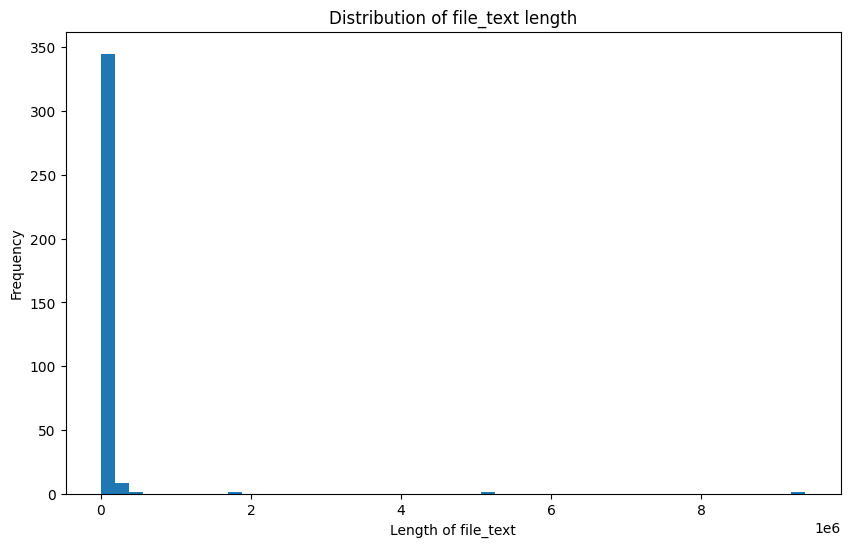

Percentage of rows with NaN in communication column: 4.6%


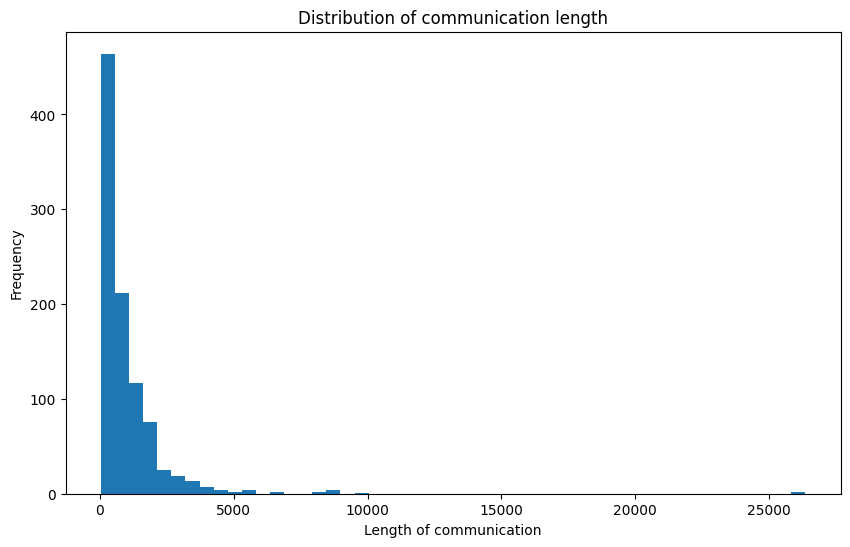

Percentage of rows with communication field less than 3000 characters: 95.38784067085953%


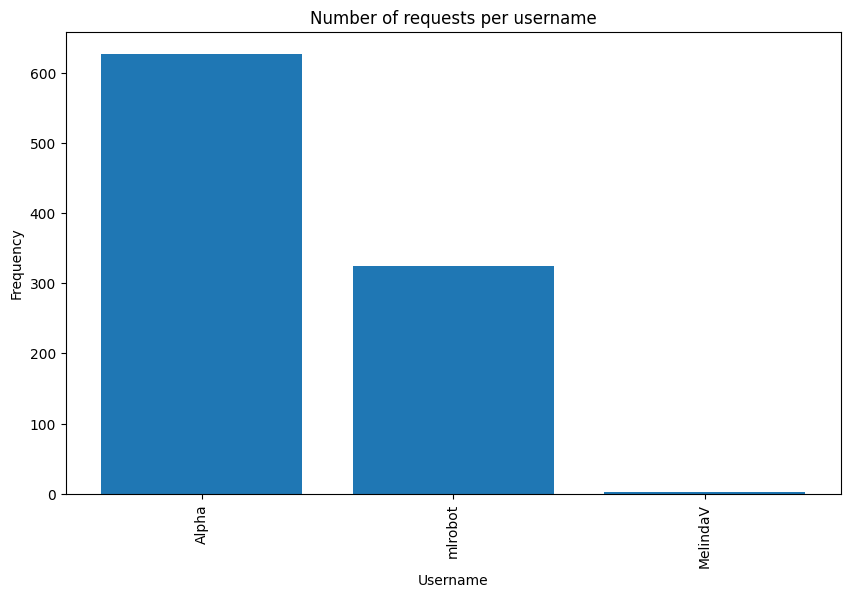

In [2]:
import matplotlib.pyplot as plt

df['file_text_length'] = df['file_text'].str.len()
plt.figure(figsize=(10,6))

plt.hist(df['file_text_length'].dropna(), bins=50)
plt.title('Distribution of file_text length')
plt.xlabel('Length of file_text')
plt.ylabel('Frequency')
plt.show()

nan_communication_rows = df['communication'].isna().sum()
total_rows = df.shape[0]
percent_nan_communication = (nan_communication_rows / total_rows) * 100
print(f"Percentage of rows with NaN in communication column: {percent_nan_communication}%")



df['communication_length'] = df['communication'].str.len()
df = df.dropna(subset=['communication_length'])

plt.figure(figsize=(10,6))


plt.hist(df['communication_length'].dropna(), bins=50)
plt.title('Distribution of communication length')
plt.xlabel('Length of communication')
plt.ylabel('Frequency')
plt.show()

x = 3000
percent_less_than_x = (df[df['communication_length'] < x].shape[0] / df.shape[0]) * 100
print(f"Percentage of rows with communication field less than {x} characters: {percent_less_than_x}%")


username_counts = df['username'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(username_counts.index, username_counts.values)
plt.title('Number of requests per username')
plt.xlabel('Username')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()







All unique 'status' values: ['no_docs' 'processed' 'payment' 'done' 'fix' 'abandoned' 'appealing'
 'rejected' 'partial']


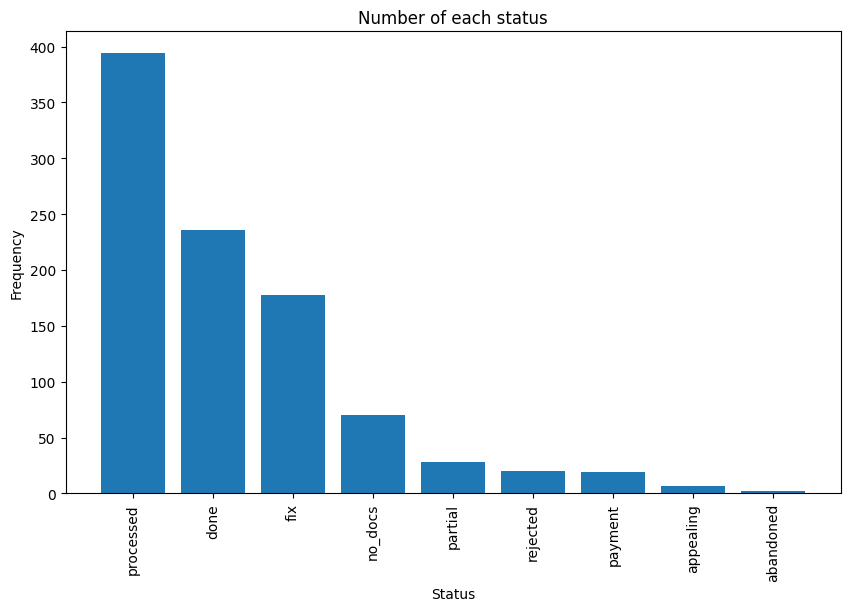

In [3]:
unique_statuses = df['status'].unique()
print(f"All unique 'status' values: {unique_statuses}")

def map_status(status):
    status_mapping = {
        'no_docs': 'NO_DOCS',
        'processed': 'PROCESSED',
        'payment': 'PAYMENT',
        'done': 'DONE',
        'fix': 'FIX',
        'abandoned': 'INDETERMINATE',
        'appealing': 'INDETERMINATE',
        'rejected': 'REJECTED',
        'partial': 'PARTIAL'
    }
    return status_mapping.get(status, 'INDETERMINATE')


status_counts = df['status'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(status_counts.index, status_counts.values)
plt.title('Number of each status')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

df['status_new'] = df['status'].apply(map_status)




In [4]:
import numpy as np
import json

np.random.seed(0)

# Get unique statuses
unique_statuses = df['status'].unique()

# Initialize an empty dataframe for the samples
df_sample = pd.DataFrame()

# Loop through each unique status and sample up to 10 records
for status in unique_statuses:
    df_status = df[df['status'] == status]
    df_sample = pd.concat([df_sample, df_status.sample(min(len(df_status), 10))])

df_sample

list_of_objects = df_sample.to_dict('records')
list_of_objects

with open('../data/data.json', 'w') as f:
    json.dump(list_of_objects, f)



In [3]:
# Generate test gloo files for each sample
# The way it works is like this:
# 1. We load the json files
# 2. Create test groups according to each status
# 3. Write each test group to a gloo file
# 4. Run the gloo compiler by Ctrl + S on any of the gloo files, which will generate python test files
# 5. Run dotenv run pytest -k "test_group".


from pydantic import BaseModel
from typing import List, Dict
from collections import defaultdict
from generated.custom_types import FoiaTestCasePayload
import json
import pandas as pd

class TestGroup(BaseModel):
    name: str
    test_cases: List[FoiaTestCasePayload]

with open("../data/data.json", "r") as f:
    data = json.load(f)

test_cases: List[FoiaTestCasePayload] = []
max_count = 70
for obj in data:
    # Set the name to the tid
    obj["name"] = str(obj["tid"])

    # Replace all nans with None
    for k, v in obj.items():
        if isinstance(v, float) and pd.isna(v):
            obj[k] = None

    test_cases.append(FoiaTestCasePayload(**obj))
    if len(test_cases) >= max_count:
        break


status_groups: Dict[str, List[FoiaTestCasePayload]] = defaultdict(list)
for case in test_cases:
    if case.status:
        status_groups[case.status].append(case)

test_groups: List[TestGroup] = []
for status, cases in status_groups.items():
    if status in ["appealing", "abandoned"]:
        continue

    suite = TestGroup(
        name=f"status_{status}",
        test_cases=cases,
    )
    test_groups.append(suite)

print(f"Generated {len(test_groups)} test groups")

# Now generate .gloo files for each test group under ../gloo/tests/test_groups.gloo

import os
import shutil
# import indent
from textwrap import indent, dedent

def convert_test_group_to_gloo_test(
    test_group: TestGroup,
) -> str:
  
  return ""



def format_field(field):
    # Replace problematic characters that break the gloo compiler
    return indent(field, "    "* 4).strip().replace("\u000c", "").replace("{", "(").replace("\\", "\\\\").replace("}", "").replace('"', '\\"').replace("'", "\\'")if field else 'None'

for group in test_groups:
    with open(f"../gloo/tests/{group.name}.gloo", "w") as f:
        test_group_string = f"@test_group {group.name} for ProcessRequestTestWrapper {{\n"
        for case in group.test_cases:
            communication = format_field(case.communication)
            file_text = format_field(case.file_text)
            case_string = f"""
        @case {case.name} {{
            @input {{
                FoiaTestCasePayload(
                    name="{case.name}",
                    tid={case.tid},
                    cid={case.cid},
                    username="{case.username}",
                    communication=\"\"\"{communication}\"\"\",
                    file_text=\"\"\"{file_text}\"\"\",
                    status="{case.status if case.status else 'None'}",
                    tracking_number="{case.tracking_number if case.tracking_number else 'None'}",
                    date_estimate="{case.date_estimate if case.date_estimate else 'None'}",
                    price={case.price if case.price else 'None'}
                )
            }}
        }}\n"""
            test_group_string += case_string
        test_group_string += "}\n"
        f.write(test_group_string)



Generated 7 test groups
